In [197]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [198]:
import glob
import os
import PIL
import time

from IPython import display

In [199]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [200]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [201]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [202]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [203]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Now, we transfer the weights of discriminator except the last layer to a new model, add a dense layer with 128 units, and add another dense layer with 10 units and softmax activation.

In [204]:
disc = checkpoint.discriminator

new_model = Sequential()
for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    

new_model.add(Dense(128))
new_model.add(Dense(10, activation='softmax'))
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [205]:
# view the initialized weights and bias of the second last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-2].weights

[<tf.Variable 'dense_8/kernel:0' shape=(6272, 128) dtype=float32, numpy=
 array([[-0.02609655, -0.0277319 , -0.01037567, ..., -0.02093641,
          0.00127452,  0.02796417],
        [-0.00387016,  0.00666747, -0.005854  , ..., -0.01654186,
          0.01097797,  0.01626744],
        [ 0.00509787, -0.0072868 ,  0.00383682, ...,  0.0160715 ,
         -0.00372962,  0.00061158],
        ...,
        [ 0.01429519, -0.01360933, -0.00437338, ...,  0.02191745,
         -0.01989727,  0.00432507],
        [-0.00119202, -0.00494785,  0.00560394, ...,  0.02623169,
         -0.00168538, -0.01669791],
        [ 0.01921036,  0.02625481, -0.00265148, ...,  0.0235343 ,
         -0.0189764 , -0.01796405]], dtype=float32)>,
 <tf.Variable 'dense_8/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [206]:
(train_img, train_lb), (test_img, test_lb) = tf.keras.datasets.mnist.load_data()

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
np.random.seed(42)
trainsize = 10000  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 10000  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) 

(10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


In [207]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=7,
                        validation_data=(test_images, test_labels))


Epoch 1/7
100/100 [==============================] - 9s 89ms/step - loss: 1.4209 - accuracy: 0.6285 - val_loss: 0.9118 - val_accuracy: 0.8189
Epoch 2/7
100/100 [==============================] - 8s 75ms/step - loss: 0.8009 - accuracy: 0.8194 - val_loss: 0.6481 - val_accuracy: 0.8583
Epoch 3/7
100/100 [==============================] - 8s 77ms/step - loss: 0.6263 - accuracy: 0.8496 - val_loss: 0.5370 - val_accuracy: 0.8740
Epoch 4/7
100/100 [==============================] - 8s 78ms/step - loss: 0.5414 - accuracy: 0.8608 - val_loss: 0.4740 - val_accuracy: 0.8855
Epoch 5/7
100/100 [==============================] - 8s 79ms/step - loss: 0.4875 - accuracy: 0.8746 - val_loss: 0.4311 - val_accuracy: 0.8944
Epoch 6/7
100/100 [==============================] - 7s 74ms/step - loss: 0.4492 - accuracy: 0.8799 - val_loss: 0.4011 - val_accuracy: 0.9002
Epoch 7/7
100/100 [==============================] - 8s 77ms/step - loss: 0.4193 - accuracy: 0.8899 - val_loss: 0.3777 - val_accuracy: 0.9050


In [208]:
# unfreeze all layers 
for layer in new_model.layers:
    layer.trainable = True

# optimizer=new_model.optimizer
# optimizer.learning_rate=0.005
    
new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = new_model.fit(train_images, train_labels, batch_size=100, epochs=8,
                        validation_data=(test_images, test_labels)) 


Epoch 1/8
100/100 [==============================] - 13s 130ms/step - loss: 0.3584 - accuracy: 0.8935 - val_loss: 0.3046 - val_accuracy: 0.9136
Epoch 2/8
100/100 [==============================] - 13s 126ms/step - loss: 0.3154 - accuracy: 0.9048 - val_loss: 0.2778 - val_accuracy: 0.9205
Epoch 3/8
100/100 [==============================] - 13s 126ms/step - loss: 0.2916 - accuracy: 0.9131 - val_loss: 0.2602 - val_accuracy: 0.9246
Epoch 4/8
100/100 [==============================] - 13s 127ms/step - loss: 0.2690 - accuracy: 0.9197 - val_loss: 0.2462 - val_accuracy: 0.9273
Epoch 5/8
100/100 [==============================] - 13s 126ms/step - loss: 0.2513 - accuracy: 0.9261 - val_loss: 0.2292 - val_accuracy: 0.9321
Epoch 6/8
100/100 [==============================] - 13s 126ms/step - loss: 0.2347 - accuracy: 0.9288 - val_loss: 0.2177 - val_accuracy: 0.9360
Epoch 7/8
100/100 [==============================] - 13s 126ms/step - loss: 0.2222 - accuracy: 0.9340 - val_loss: 0.2074 - val_accuracy:

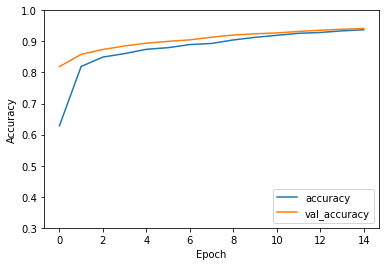

In [209]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.94 after 15 epochs.

actual label: 7


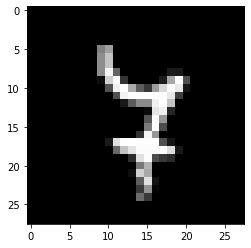

[[6.5365425e-06 1.0835814e-02 1.5076936e-02 6.1232589e-02 2.4876423e-02
  3.1130216e-03 2.1443324e-04 8.7502033e-01 2.9096706e-03 6.7142393e-03]]
prediction: 7


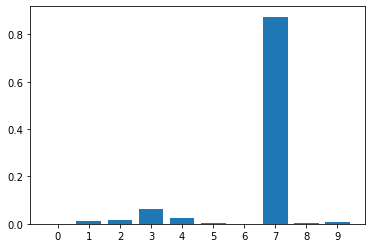

In [287]:
# demonstration: predict the ith test digit
i = np.random.randint(0, trainsize)

# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

# predict
prediction = new_model.predict(test_images[i].reshape(1,28,28,1))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), prediction[0,:])
plt.show()

**Get Confusion Matrix**

In [211]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

In [212]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat

array([[ 958,    0,    2,    1,    1,    6,    9,    1,    2,    0],
       [   0, 1112,    4,    2,    0,    3,    4,    0,   10,    0],
       [  10,    1,  960,   15,   10,    2,    4,   11,   16,    3],
       [   0,    0,   14,  960,    1,   13,    0,   10,    8,    4],
       [   2,    2,    4,    2,  927,    1,   13,    2,    8,   21],
       [   4,    1,    1,   18,    0,  841,   10,    2,   10,    5],
       [  13,    3,    5,    1,   10,    7,  916,    0,    3,    0],
       [   3,    5,   27,   11,    3,    2,    0,  942,    2,   33],
       [   5,    3,   11,   17,    6,   18,    7,   10,  885,   12],
       [  10,    5,    2,   14,   23,   11,    0,   17,    9,  918]])

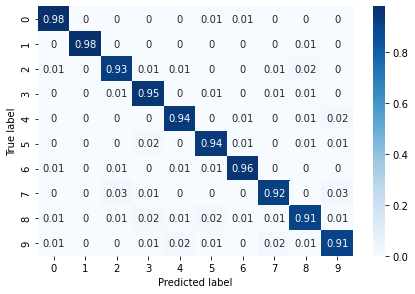

In [213]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)

figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Generate new digits and perform classification on them using our model**

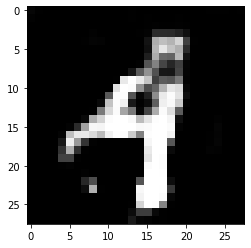

In [593]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
fig = plt.figure()
plt.imshow(sample[0, :, :, 0], cmap='gray')

[[1.17587626e-06 2.61588951e-07 1.12175139e-05 3.84650484e-04
  9.89725649e-01 5.12012521e-05 2.99884923e-05 5.82423636e-05
  1.17979886e-04 9.61967837e-03]]
prediction: 4


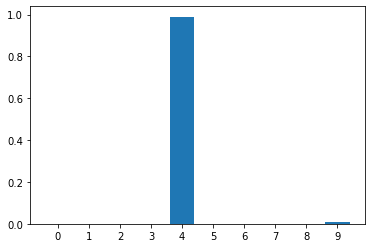

In [594]:
new_sample = sample[0, :, :, 0].numpy().reshape(1,28,28,1)
new_prediction = new_model.predict(new_sample)

# get probability distribution and classification of the test digit
print(new_prediction)
print('prediction:', np.argmax(new_prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), new_prediction[0,:])
plt.show()

In [595]:
# we can save the numpy array of appropriately generated digits as .npy file,
# which could be used for further training
np.save('generated_numpy.npy', sample[0, :, :, 0].numpy())

In [596]:
# upload the saved numpy array
arr = np.load('generated_numpy.npy')
arr

array([[-9.49534893e-01, -9.86528456e-01, -9.99285519e-01,
        -9.97798085e-01, -9.98131394e-01, -9.95345831e-01,
        -9.98467088e-01, -9.96410429e-01, -9.97210026e-01,
        -9.95588899e-01, -9.98214006e-01, -9.94818628e-01,
        -9.95189965e-01, -9.90433812e-01, -9.96758103e-01,
        -9.93207753e-01, -9.95950997e-01, -9.94643390e-01,
        -9.98383582e-01, -9.94490623e-01, -9.95909452e-01,
        -9.93099272e-01, -9.95687783e-01, -9.84543502e-01,
        -9.91695166e-01, -9.88400519e-01, -9.95296717e-01,
        -9.90459859e-01],
       [-9.79973137e-01, -9.97185290e-01, -9.99705136e-01,
        -9.98787701e-01, -9.98795152e-01, -9.97791350e-01,
        -9.98740435e-01, -9.96048748e-01, -9.98191237e-01,
        -9.97793138e-01, -9.98917401e-01, -9.95453119e-01,
        -9.94757175e-01, -9.90256965e-01, -9.96375024e-01,
        -9.88713682e-01, -9.93646681e-01, -9.92658973e-01,
        -9.97341037e-01, -9.89845634e-01, -9.94903684e-01,
        -9.93302286e-01, -9.95